### Histogram creatinon and save

In [3]:
"""Data utilities to grab data from google cloud bucket.

Meant to be used for both training and prediction so the model is
trained on exactly the same data that will be used for predictions.
"""

from __future__ import annotations

import io
import logging
import os
import re
import tempfile
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict

import google.auth
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests
from serving.constants import (
    BUCKET,
    HIST_BINS_LIST,
    HIST_DEST_PREFIX,
    IMG_SOURCE_PREFIX,
    SELECTED_BANDS,
    PROJECT,
    PIX_COUNT,
    REFLECTANCE_CONST,
    NUM_BINS,
    MAP_NAN,
    NORMALIZE
)
from google.api_core import exceptions, retry
from google.cloud import storage
from numpy.lib.recfunctions import structured_to_unstructured
from osgeo import gdal
from rasterio.io import MemoryFile
from serving.common import list_blobs_with_prefix

logging.basicConfig(
    filename="hist.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)


def hist_init():
    """Authenticate and initialize Earth Engine with the default credentials."""
    # Use the Earth Engine High Volume endpoint.
    #   https://developers.google.com/earth-engine/cloud/highvolume
    credentials, project = google.auth.default()

def process_band(bucket, blob_name, band, bins, skip_nan, normalise):

    storage_client = storage.Client()
    blob = storage_client.bucket(bucket).blob(blob_name)

    with blob.open("rb") as f:
        with rasterio.open(f) as src:

            data = src.read(band).flatten()
            na_mask = np.isnan(data)
            
            if skip_nan == False:
                data[na_mask] = 0.0
                valid_data = data
            else:
                valid_data = data[~na_mask]
                
            if normalise:
                valid_data = valid_data / REFLECTANCE_CONST
                bins = bins / REFLECTANCE_CONST
                
            valid_max = np.max(valid_data)
            valid_min = np.min(valid_data)

            if valid_max > bins[-1]:
                logging.warning(
                    f"image: {blob_name}, band: {band}, {valid_max} value is larger than assumed possible values for this band: {bins[-1]}"
                )
            elif valid_min < bins[0]:
                logging.warning(
                    f"image: {blob_name}, band: {band}, {valid_min} value is smaller than assumed possible values for this band {bins[0]}"
                )
            
            if valid_data.size > 0:
                total_sum = np.sum(valid_data)
                total_count = valid_data.size
                mean = total_sum / total_count
                hist, _ = np.histogram(valid_data, bins=bins, density=False)
            else:
                logging.error(f"image: {blob_name}, band: {band} has 0 valid pixels. Investigate")
                mean = np.nan
                hist = np.zeros_like(
                    bins[:-1]
                )  # histogram will have one less element than bins

    return hist


def process_tiff(bucket, blob_name, bin_list, selected_bands, skip_nan, normalise, max_workers=6):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_band = {
            executor.submit(
                process_band, bucket, blob_name, band, bins, skip_nan, normalise
            ): band
            for band, bins in zip(selected_bands, bin_list)
        }
        results = []

        for future in as_completed(future_to_band):
            band = future_to_band[future]
            try:
                result = future.result()
                results.append(result)
                logging.info(f"Processed band {band} successfully")
            except Exception as exc:
                logging.exception(f"Band {band} generated an exception: {exc}")

    sorted_results = sorted(results, key=lambda x: x[0])
    return np.array(sorted_results).flatten()  # one long array instead of bands


def recombine_image(bucket, core_image_name, bin_list, selected_bands, skip_nan=False, normalise=False):
    start_time = time.time()

    hist_per_blob = []
    blobs = list_blobs_with_prefix(core_image_name)
    for blob in blobs:
        results = process_tiff(bucket, blob.name, bin_list, selected_bands, skip_nan, normalise)
        hist_per_blob.append(results)

    combined_hist = np.sum(np.array(hist_per_blob), axis=0)

    end_time = time.time()
    execution_time = end_time - start_time
    logging.info(
        f"Image {core_image_name} has been processed in {execution_time/60:.4f} minuntes"
    )

    return combined_hist

def write_histogram_to_gcs(histogram, bucket_name, blob_name):
    """
    Write a NumPy array (histogram) to Google Cloud Storage.

    Args:
    histogram (np.array): The histogram to save.
    bucket_name (str): The name of the GCS bucket.
    blob_name (str): The name to give the file in GCS (including any 'path').

    Returns:
    str: The public URL of the uploaded file.
    """
    # Ensure the blob_name ends with .npy
    if not blob_name.endswith('.npy'):
        blob_name += '.npy'

    # Create a GCS client
    client = storage.Client()

    # Get the bucket
    bucket = client.bucket(bucket_name)

    # Create a blob
    blob = bucket.blob(blob_name)

    # Convert the numpy array to bytes
    array_bytes = io.BytesIO()
    np.save(array_bytes, histogram)
    array_bytes.seek(0)

    # Upload the bytes to GCS
    blob.upload_from_file(array_bytes, content_type='application/octet-stream')

    logging.info(f"Histogram uploaded to gs://{bucket_name}/{blob_name}")



ModuleNotFoundError: No module named 'osgeo'

#### Single histogram creation and save

In [2]:
image_name="images/60/Bailey_48/2016/7-8"
file_name="histograms/nan_map_True/norm_True/8_buckets_3_bands/60/Bailey_48/2016/7-8.npy"

In [3]:
hist_post = recombine_image(BUCKET, image_name, HIST_BINS_LIST, SELECTED_BANDS, MAP_NAN, NORMALIZE)

In [4]:
hist_post

array([], dtype=float64)

In [5]:
client = storage.Client()
bucket = client.get_bucket(BUCKET)
hist_blob = bucket.blob(file_name)
content = hist_blob.download_as_bytes()
binary_data = io.BytesIO(content)
array = np.load(binary_data)

In [6]:
array

array([    0,    13,    23,   660,  5679, 11719,  7287,  1266,     0,
          19,    22,  1045,  7486, 12781,  4855,   488,     0,    15,
          19,    95,  2379,  8653, 11293,  3763], dtype=int64)

In [7]:
lstm_hist = array.reshape(len(HIST_BINS_LIST),NUM_BINS)
lstm_hist

array([[    0,    13,    23,   660,  5679, 11719,  7287,  1266],
       [    0,    19,    22,  1045,  7486, 12781,  4855,   488],
       [    0,    15,    19,    95,  2379,  8653, 11293,  3763]],
      dtype=int64)

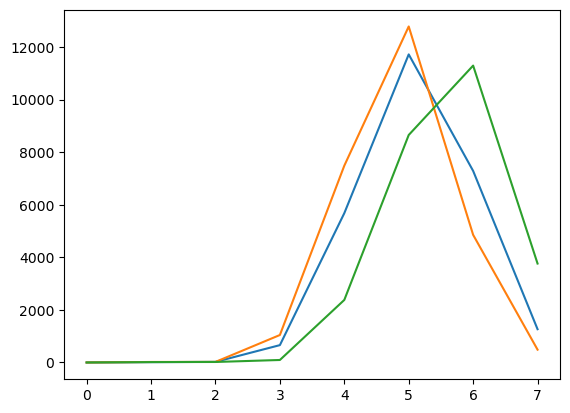

In [8]:
for y in lstm_hist:
    plt.plot(y)
plt.show()

In [9]:
lstm_hist.shape

(3, 8)

In [ ]:
skip_nan = True
normalise = True
idx = 0
bins = HIST_BINS_LIST[idx]
blob_name = image_name + ".tif"
storage_client = storage.Client()
blob = storage_client.bucket(BUCKET).blob(blob_name)
band = SELECTED_BANDS[idx]
with blob.open("rb") as f:
    with rasterio.open(f) as src:

        data = src.read(band).flatten()
        na_mask = np.isnan(data)

        if skip_nan == False:
            data[na_mask] = 0.0
            valid_data = data
        else:
            valid_data = data[~na_mask]

        if normalise:
            valid_data = valid_data / REFLECTANCE_CONST
            bins = bins / REFLECTANCE_CONST

        valid_max = np.max(valid_data)
        valid_min = np.min(valid_data)

        if valid_max > bins[-1]:
            logging.warning(
                f"image: {blob_name}, band: {band}, {valid_max} value is larger than assumed possible values for this band: {bins[-1]}"
            )
        elif valid_min < bins[0]:
            logging.warning(
                f"image: {blob_name}, band: {band}, {valid_min} value is smaller than assumed possible values for this band {bins[0]}"
            )

        if valid_data.size > 0:
            total_sum = np.sum(valid_data)
            total_count = valid_data.size
            mean = total_sum / total_count
            hist, _ = np.histogram(valid_data, bins=bins, density=False)
        else:
            logging.error(f"image: {blob_name}, band: {band} has 0 valid pixels. Investigate")
            mean = np.nan
            hist = np.zeros_like(
                bins[:-1]
            ) 

In [39]:
array

array([    0,    13,    23,   660,  5679, 11719,  7287,  1266,     0,
          19,    22,  1045,  7486, 12781,  4855,   488,     0,    15,
          19,    95,  2379,  8653, 11293,  3763])

#### List of histograms combined into one

In [2]:
file_names = ["histograms/nan_map_True/norm_True/8_buckets_3_bands/60/Bailey_48/2016/5-6.npy",
             "histograms/nan_map_True/norm_True/8_buckets_3_bands/60/Bailey_48/2016/7-8.npy",
             "histograms/nan_map_True/norm_True/8_buckets_3_bands/60/Bailey_48/2016/9-10.npy"]

client = storage.Client()
bucket = client.get_bucket(BUCKET)

NameError: name 'storage' is not defined

In [10]:
hist_per_blob = []

for file_name in file_names:
    hist_blob = bucket.blob(file_name)
    content = hist_blob.download_as_bytes()
    binary_data = io.BytesIO(content)
    array = np.load(binary_data)
    hist_per_blob.append(array)


In [1]:
hist_per_blob = np.array(hist_per_blob)
hist_per_blob.shape

NameError: name 'np' is not defined

In [17]:
hist_per_blob


array([[    1,   117,   231,   832,  5365, 14727,  4987,   413,     2,
          120,   428,  1928, 12437, 10440,  1238,   137,     2,   125,
          460,  2036, 13586,  9566,   861,   122],
       [    0,    13,    23,   660,  5679, 11719,  7287,  1266,     0,
           19,    22,  1045,  7486, 12781,  4855,   488,     0,    15,
           19,    95,  2379,  8653, 11293,  3763],
       [    1,     3,  1898,  8255, 11133,  4814,   491,   105,     2,
            3,  2078,  8476, 11367,  4334,   364,   112,     2,     1,
          689,  5198, 10252,  8798,  1518,   192]], dtype=int64)

In [20]:
# case when one histogram is split into multiple files
np.sum(hist_per_blob, axis=0)

array([    2,   133,  2152,  9747, 22177, 31260, 12765,  1784,     4,
         142,  2528, 11449, 31290, 27555,  6457,   737,     4,   141,
        1168,  7329, 26217, 27017, 13672,  4077], dtype=int64)

### Numpy array to dataset